In [1]:
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

In [2]:
# Для ознакомления загрузим 1 часть дынных из 12.

df = pd.read_parquet('train_data/train_data_0.pq').astype('int32')
print(df.shape)
df.head(20)

(1974724, 61)


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0
5,0,6,5,0,11,8,12,11,4,2,...,3,3,3,4,1,2,3,1,0,1
6,0,7,3,9,1,2,12,14,15,5,...,3,3,3,4,1,3,4,1,0,0
7,0,8,2,9,2,3,12,14,15,5,...,3,3,3,4,1,3,4,1,0,0
8,0,9,1,9,11,13,14,8,2,5,...,3,3,3,4,1,2,4,1,0,0
9,0,10,7,9,2,10,8,8,16,4,...,3,3,3,4,1,2,4,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Data columns (total 61 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int32
 1   rn                             int32
 2   pre_since_opened               int32
 3   pre_since_confirmed            int32
 4   pre_pterm                      int32
 5   pre_fterm                      int32
 6   pre_till_pclose                int32
 7   pre_till_fclose                int32
 8   pre_loans_credit_limit         int32
 9   pre_loans_next_pay_summ        int32
 10  pre_loans_outstanding          int32
 11  pre_loans_total_overdue        int32
 12  pre_loans_max_overdue_sum      int32
 13  pre_loans_credit_cost_rate     int32
 14  pre_loans5                     int32
 15  pre_loans530                   int32
 16  pre_loans3060                  int32
 17  pre_loans6090                  int32
 18  pre_loans90                    int32
 19  

In [4]:
# Проверка на строки-дубликаты.
len(df[df.duplicated()])

0

In [5]:
# Проверка на пропуски.
df.isna().sum().sum()

0

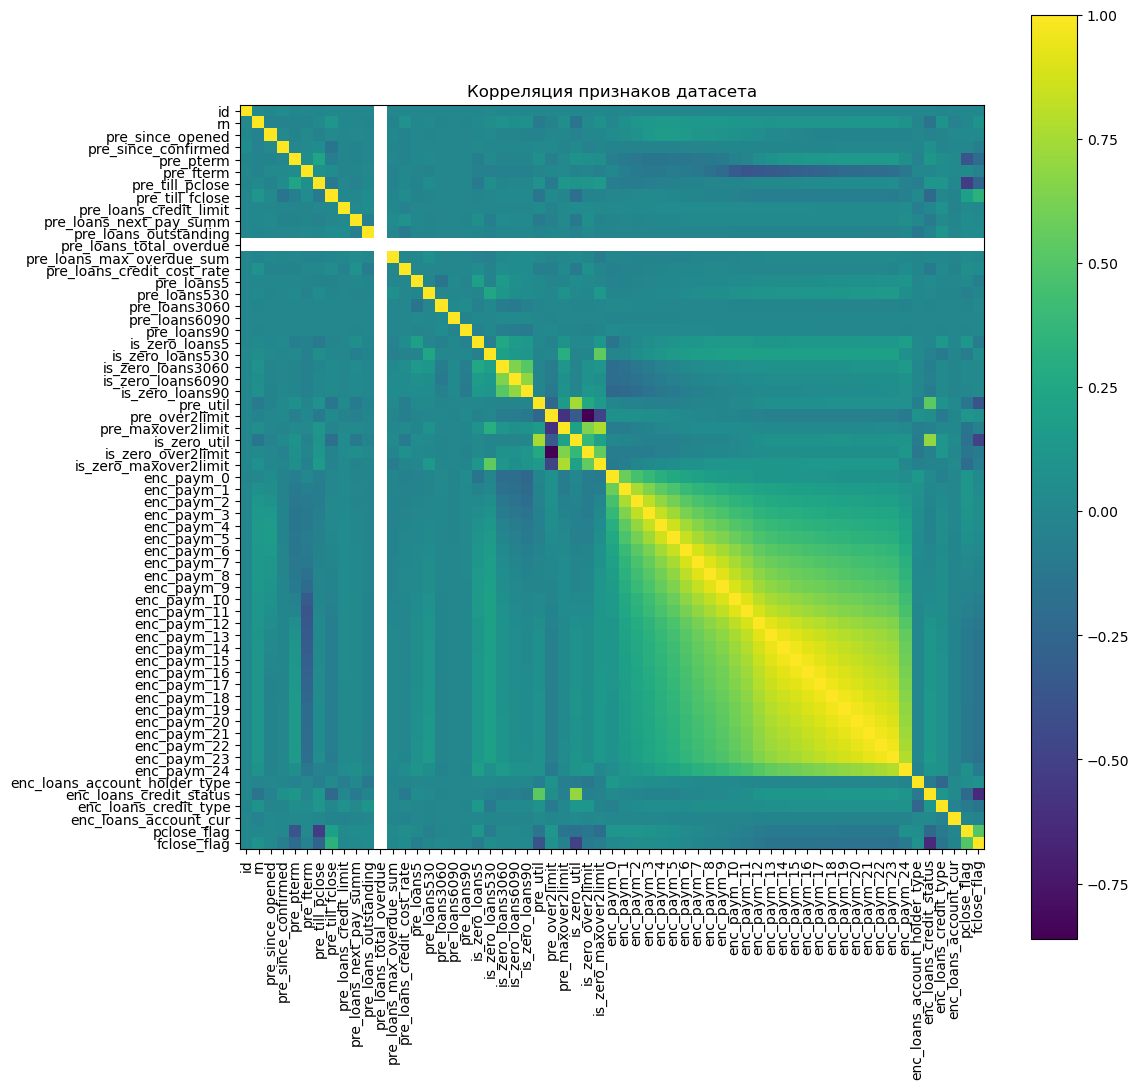

In [6]:
# Матрица корреляций
plt.figure(figsize=(12, 12))

columns = df.corr().columns.tolist()
plt.imshow(df.corr())

plt.title("Корреляция признаков датасета")
plt.xticks(range(0, len(columns)), columns, rotation=90)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show()

# Один признак состоит из единственного значения.
# Признаки "статусы ежемесячных платежей" имеют высокую корреляцию по смежным месяцам.
# Несколько признаков имеют высокую обратную корреляцию.

In [7]:
df.columns

Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

In [8]:
# Список бинаризированных колонок.
binary_cols = ['pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm', 'pre_till_pclose', 'pre_till_fclose', 
               'pre_loans_credit_limit', 'pre_loans_next_pay_summ', 'pre_loans_outstanding', 'pre_loans_total_overdue', 
               'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530', 'pre_loans3060',
               'pre_loans6090', 'pre_loans90', 'pre_util', 'pre_over2limit','pre_maxover2limit']

print(len(binary_cols))    # и его длинна

20


In [9]:
# Ознакомление со значениями бинаризированных колонок.
for column in binary_cols:    
    column_name = df[column]
    print(f"Характеристика: {column} \nКоличество уникальных значений: {column_name.nunique()} \nСписок значений: \n{column_name.value_counts(dropna=False)} \n")

Характеристика: pre_since_opened 
Количество уникальных значений: 20 
Список значений: 
18    159072
6     154230
13    141904
4     138266
8     133032
0     111331
7      96090
19     94237
2      91807
10     91017
9      90118
17     86449
1      85775
11     82871
3      82231
5      80730
14     78560
15     73219
12     71609
16     32176
Name: pre_since_opened, dtype: int64 

Характеристика: pre_since_confirmed 
Количество уникальных значений: 18 
Список значений: 
9     418663
6     169181
14    134266
3     123579
17    116876
4     106465
8     101021
7      99650
13     84393
10     83769
0      80598
12     79820
2      77607
1      76836
16     75548
5      74440
11     71962
15        50
Name: pre_since_confirmed, dtype: int64 

Характеристика: pre_pterm 
Количество уникальных значений: 18 
Список значений: 
4     374796
14    152466
7     126906
2     121765
16    110465
17    109905
8     109871
9     109775
1     108185
13    105364
15    102845
11     94518
12     90

In [10]:
# Список закодированных признаков.
coded_cols = ['enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
              'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13', 'enc_paym_14',
              'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21',
              'enc_paym_22', 'enc_paym_23', 'enc_paym_24', 'enc_loans_account_holder_type', 'enc_loans_credit_status',
              'enc_loans_credit_type', 'enc_loans_account_cur']

print(len(coded_cols))

29


In [11]:
# Ознакомление со значениями закодированных признаков.
for column in coded_cols:    
    column_name = df[column]
    print(f"Характеристика: {column} \nКоличество уникальных значений: {column_name.nunique()} \nСписок значений: \n{column_name.value_counts(dropna=False)} \n")

Характеристика: enc_paym_0 
Количество уникальных значений: 4 
Список значений: 
0    1791770
3      88319
1      87480
2       7155
Name: enc_paym_0, dtype: int64 

Характеристика: enc_paym_1 
Количество уникальных значений: 4 
Список значений: 
0    1635644
3     205080
1     124300
2       9700
Name: enc_paym_1, dtype: int64 

Характеристика: enc_paym_2 
Количество уникальных значений: 4 
Список значений: 
0    1556292
3     299304
1     110228
2       8900
Name: enc_paym_2, dtype: int64 

Характеристика: enc_paym_3 
Количество уникальных значений: 4 
Список значений: 
0    1474594
3     386940
1     104846
2       8344
Name: enc_paym_3, dtype: int64 

Характеристика: enc_paym_4 
Количество уникальных значений: 4 
Список значений: 
0    1383266
3     486048
1      97863
2       7547
Name: enc_paym_4, dtype: int64 

Характеристика: enc_paym_5 
Количество уникальных значений: 4 
Список значений: 
0    1300408
3     576932
1      90451
2       6933
Name: enc_paym_5, dtype: int64 

Хара

In [12]:
# Список признаков-флагов.
flag_cols = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90', 'is_zero_util',
             'is_zero_over2limit', 'is_zero_maxover2limit', 'pclose_flag', 'fclose_flag' ]

print(len(flag_cols))

10


In [13]:
# Ознакомление со значениями признаков-флагов.
for column in flag_cols:    
    column_name = df[column]
    print(f"Характеристика: {column} \nКоличество уникальных значений: {column_name.nunique()} \nСписок значений: \n{column_name.value_counts(dropna=False)} \n")

Характеристика: is_zero_loans5 
Количество уникальных значений: 2 
Список значений: 
1    1786965
0     187759
Name: is_zero_loans5, dtype: int64 

Характеристика: is_zero_loans530 
Количество уникальных значений: 2 
Список значений: 
1    1642360
0     332364
Name: is_zero_loans530, dtype: int64 

Характеристика: is_zero_loans3060 
Количество уникальных значений: 2 
Список значений: 
1    1893250
0      81474
Name: is_zero_loans3060, dtype: int64 

Характеристика: is_zero_loans6090 
Количество уникальных значений: 2 
Список значений: 
1    1932487
0      42237
Name: is_zero_loans6090, dtype: int64 

Характеристика: is_zero_loans90 
Количество уникальных значений: 2 
Список значений: 
1    1933862
0      40862
Name: is_zero_loans90, dtype: int64 

Характеристика: is_zero_util 
Количество уникальных значений: 2 
Список значений: 
1    1404635
0     570089
Name: is_zero_util, dtype: int64 

Характеристика: is_zero_over2limit 
Количество уникальных значений: 2 
Список значений: 
1    1862

In [14]:
# Для более глубокого ознакомления выведем три разные категории признаков раздельно.
pd.set_option('display.max_columns', None)  # задействуем опцию "показывать все колонки"

In [15]:
df[binary_cols]   # бинаризированные

,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,pre_util,pre_over2limit,pre_maxover2limit
0,18,9,2,3,16,10,11,3,3,0,2,11,6,16,5,4,8,16,2,17
1,18,9,14,14,12,12,0,3,3,0,2,11,6,16,5,4,8,16,2,17
2,18,9,4,8,1,11,11,0,5,0,2,8,6,16,5,4,8,15,2,17
3,4,1,9,12,16,7,12,2,3,0,2,4,6,16,5,4,8,16,2,17
4,5,12,15,2,11,12,10,2,3,0,2,4,6,16,5,4,8,16,2,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,1,9,14,8,10,11,8,4,2,0,2,4,6,16,5,4,8,11,2,17
1974720,7,9,4,8,1,11,19,1,4,0,2,7,6,16,5,4,8,7,2,17
1974721,9,0,10,8,10,11,16,2,3,0,2,7,6,16,5,4,8,16,2,17
1974722,9,16,10,13,10,4,12,2,3,0,2,7,6,16,5,4,8,16,2,17


In [16]:
df[coded_cols]     # закодированные

,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur
0,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,3,4,1
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,2,3,1
3,1,0,0,0,0,0,0,0,0,0,0,1,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,1,1
4,0,0,0,0,0,0,0,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,0,0,0,0,0,0,0,0,0,0,0,1,0,3,3,3,3,3,3,3,4,3,3,3,4,1,2,3,1
1974720,0,0,0,0,0,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,4,1
1974721,0,0,0,0,0,0,0,0,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,3,1
1974722,0,0,0,0,0,0,0,0,0,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,2,3,1


In [17]:
df[flag_cols]     # признаки-флаги

,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag
0,1,1,1,1,1,1,1,1,0,0
1,1,1,1,1,1,1,1,1,0,0
2,1,1,1,1,1,0,1,1,1,1
3,0,1,1,1,1,1,1,1,0,0
4,1,1,1,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1974719,1,1,1,1,1,0,1,1,0,1
1974720,1,1,1,1,1,0,1,1,1,1
1974721,1,1,1,1,1,1,1,1,0,1
1974722,1,1,1,1,1,1,1,1,0,0


In [18]:
# Так как бинаризированные и закодированные признаки "обезличены", мы не знаем, какие реальные значения скрываются за их числами.
# Принимаем решение с этими признаками работать, как с категориальными.

ohe_cols = binary_cols + coded_cols
print(len(ohe_cols))

49


In [19]:
# Задействуем гиперпараметр "min_frequency".
# Значения категорий, встречающиеся количество раз меньше определенного значения, будут помещены в одну категорию 'infrequent'.
# Это позволит сэкономить как оперативную память, так и время обработки данных, и снизить вероятность переобучения.
# Также, согласно проведенному эксперименту, значение метрики чуть выше с этим гиперпараметром, чем без него.
# Еще пропишем гиперпараметр 'dtype' для экономии оперативной памяти.

ohe = OneHotEncoder(min_frequency=250, sparse_output=False, dtype='int8')

In [20]:
ohe_data = pd.DataFrame(ohe.fit_transform(df[ohe_cols]), columns=ohe.get_feature_names_out())
ohe_data.shape

(1974724, 343)

In [21]:
# Объединяем признаки после "горячего кодирования" с основным датафреймом и удаляем отработанные колонки.

df = df.join(ohe_data).drop(columns=ohe_cols)
print(df.shape)
df.head()

(1974724, 355)


,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,pre_since_opened_10,pre_since_opened_11,pre_since_opened_12,pre_since_opened_13,pre_since_opened_14,pre_since_opened_15,pre_since_opened_16,pre_since_opened_17,pre_since_opened_18,pre_since_opened_19,pre_since_confirmed_0,pre_since_confirmed_1,pre_since_confirmed_2,pre_since_confirmed_3,pre_since_confirmed_4,pre_since_confirmed_5,pre_since_confirmed_6,pre_since_confirmed_7,pre_since_confirmed_8,pre_since_confirmed_9,pre_since_confirmed_10,pre_since_confirmed_11,pre_since_confirmed_12,pre_since_confirmed_13,pre_since_confirmed_14,pre_since_confirmed_16,pre_since_confirmed_17,pre_since_confirmed_infrequent_sklearn,pre_pterm_0,pre_pterm_1,pre_pterm_2,pre_pterm_3,pre_pterm_4,pre_pterm_6,pre_pterm_7,pre_pterm_8,pre_pterm_9,pre_pterm_10,pre_pterm_11,pre_pterm_12,pre_pterm_13,pre_pterm_14,pre_pterm_15,pre_pterm_16,pre_pterm_17,pre_pterm_infrequent_sklearn,pre_fterm_0,pre_fterm_1,pre_fterm_2,pre_fterm_3,pre_fterm_5,pre_fterm_6,pre_fterm_7,pre_fterm_8,pre_fterm_9,pre_fterm_10,pre_fterm_11,pre_fterm_12,pre_fterm_13,pre_fterm_14,pre_fterm_15,pre_fterm_16,pre_fterm_infrequent_sklearn,pre_till_pclose_0,pre_till_pclose_1,pre_till_pclose_2,pre_till_pclose_3,pre_till_pclose_4,pre_till_pclose_5,pre_till_pclose_6,pre_till_pclose_7,pre_till_pclose_8,pre_till_pclose_9,pre_till_pclose_10,pre_till_pclose_11,pre_till_pclose_12,pre_till_pclose_13,pre_till_pclose_14,pre_till_pclose_15,pre_till_pclose_16,pre_till_fclose_0,pre_till_fclose_1,pre_till_fclose_2,pre_till_fclose_3,pre_till_fclose_4,pre_till_fclose_5,pre_till_fclose_6,pre_till_fclose_7,pre_till_fclose_8,pre_till_fclose_9,pre_till_fclose_10,pre_till_fclose_11,pre_till_fclose_12,pre_till_fclose_13,pre_till_fclose_14,pre_till_fclose_15,pre_loans_credit_limit_0,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_0,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_outstanding_1,pre_loans_outstanding_2,pre_loans_outstanding_3,pre_loans_outstanding_4,pre_loans_outstanding_5,pre_loans_total_overdue_0,pre_loans_max_overdue_sum_1,pre_loans_max_overdue_sum_2,pre_loans_max_overdue_sum_3,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credit_cost_rate_10,pre_loans_credit_cost_rate_11,pre_loans_credit_cost_rate_13,pre_loans_credit_cost_rate_infrequent_sklearn,pre_loans5_0,pre_loans5_3,pre_loans5_5,pre_loans5_6,pre_loans5_infrequent_sklearn,pre_loans530_0,pre_loans530_2,pre_loans530_3,pre_loans530_6,pre_loans530_13,pre_loans530_16,pre_loans530_18,pre_loans530_infrequent_sklearn,pre_loans3060_5,pre_loans3060_8,pre_loans3060_infrequent_sklearn,pre_loans6090_4,pre_loans6090_infrequent_sklearn,pre_loans90_8,pre_loans90_14,pre_loans90_infrequent_sklearn,pre_util_0,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_7,pre_util_8,pre_util_9,pre_util_10,pre_util_11,pre_util_12,pre_util_13,pre_util_14,pre_util_15,pre_util_16,pre_uti

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974724 entries, 0 to 1974723
Columns: 355 entries, id to enc_loans_account_cur_infrequent_sklearn
dtypes: int32(12), int8(343)
memory usage: 736.3 MB


**Группировка датафрейма с аггрегированием.**

Признак "rn" агрегируем функцией count(). Получится новый признак, указывающий на количество кредитных продуктов в истории клиента, по которому рассматривается данная заявка.

Признаки-флаги агрегируем функцией mean(). Полученные новые признаки расскажут о доле кредитных продуктов без просрочек в определенные временные интервалы. Так флаг со значением 1, означает отсутствие просрочки, то среденне значение будет лежать в интервале от нуля до единицы. И большее значение будет говорить о большей доли кредитов без просрочек в истории клиента.

Признаки, полученные после "горячего кодирования", агрегируем суммированием. Сами по себе значения признаков нам ни о чем не говорят, но если их суммировать, то появится полезная информация. Если до агрегации мы иммели бессмысленный для на набор символов, то после агрегации, можно утверждать, что (условно) клиент в кредитной истории имел такой-то статус такое-то количество раз.

In [23]:
rn_df = df.groupby(['id'], as_index=False)[['rn']].count()
rn_df

,id,rn
0,0,10
1,1,14
2,2,3
3,3,15
4,4,1
...,...,...
249995,249995,13
249996,249996,23
249997,249997,7
249998,249998,5


In [24]:
rn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id      250000 non-null  int32
 1   rn      250000 non-null  int64
dtypes: int32(1), int64(1)
memory usage: 2.9 MB


In [25]:
flag_df = df.groupby(['id'], as_index=False)[flag_cols].mean()
flag_df

,id,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag
0,0,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.900000,0.900000,0.100000,0.200000
1,1,0.857143,0.714286,0.857143,0.857143,0.785714,0.714286,0.857143,0.785714,0.071429,0.142857
2,2,1.000000,0.666667,0.666667,0.666667,1.000000,0.333333,1.000000,0.666667,0.666667,0.666667
3,3,1.000000,1.000000,1.000000,1.000000,1.000000,0.533333,0.933333,0.933333,0.333333,0.400000
4,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
249995,249995,1.000000,0.923077,1.000000,1.000000,1.000000,0.692308,1.000000,0.923077,0.076923,0.230769
249996,249996,0.826087,0.826087,1.000000,1.000000,1.000000,0.782609,0.869565,0.739130,0.217391,0.217391
249997,249997,1.000000,0.714286,1.000000,1.000000,1.000000,1.000000,1.000000,0.857143,0.142857,0.285714
249998,249998,1.000000,0.800000,1.000000,0.800000,0.600000,0.200000,0.600000,0.600000,0.400000,0.600000


In [26]:
flag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     250000 non-null  int32  
 1   is_zero_loans5         250000 non-null  float64
 2   is_zero_loans530       250000 non-null  float64
 3   is_zero_loans3060      250000 non-null  float64
 4   is_zero_loans6090      250000 non-null  float64
 5   is_zero_loans90        250000 non-null  float64
 6   is_zero_util           250000 non-null  float64
 7   is_zero_over2limit     250000 non-null  float64
 8   is_zero_maxover2limit  250000 non-null  float64
 9   pclose_flag            250000 non-null  float64
 10  fclose_flag            250000 non-null  float64
dtypes: float64(10), int32(1)
memory usage: 20.0 MB


In [27]:
category_df = df.groupby(['id'], as_index=False)[ohe.get_feature_names_out()].sum()
category_df

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,pre_since_opened_10,pre_since_opened_11,pre_since_opened_12,pre_since_opened_13,pre_since_opened_14,pre_since_opened_15,pre_since_opened_16,pre_since_opened_17,pre_since_opened_18,pre_since_opened_19,pre_since_confirmed_0,pre_since_confirmed_1,pre_since_confirmed_2,pre_since_confirmed_3,pre_since_confirmed_4,pre_since_confirmed_5,pre_since_confirmed_6,pre_since_confirmed_7,pre_since_confirmed_8,pre_since_confirmed_9,pre_since_confirmed_10,pre_since_confirmed_11,pre_since_confirmed_12,pre_since_confirmed_13,pre_since_confirmed_14,pre_since_confirmed_16,pre_since_confirmed_17,pre_since_confirmed_infrequent_sklearn,pre_pterm_0,pre_pterm_1,pre_pterm_2,pre_pterm_3,pre_pterm_4,pre_pterm_6,pre_pterm_7,pre_pterm_8,pre_pterm_9,pre_pterm_10,pre_pterm_11,pre_pterm_12,pre_pterm_13,pre_pterm_14,pre_pterm_15,pre_pterm_16,pre_pterm_17,pre_pterm_infrequent_sklearn,pre_fterm_0,pre_fterm_1,pre_fterm_2,pre_fterm_3,pre_fterm_5,pre_fterm_6,pre_fterm_7,pre_fterm_8,pre_fterm_9,pre_fterm_10,pre_fterm_11,pre_fterm_12,pre_fterm_13,pre_fterm_14,pre_fterm_15,pre_fterm_16,pre_fterm_infrequent_sklearn,pre_till_pclose_0,pre_till_pclose_1,pre_till_pclose_2,pre_till_pclose_3,pre_till_pclose_4,pre_till_pclose_5,pre_till_pclose_6,pre_till_pclose_7,pre_till_pclose_8,pre_till_pclose_9,pre_till_pclose_10,pre_till_pclose_11,pre_till_pclose_12,pre_till_pclose_13,pre_till_pclose_14,pre_till_pclose_15,pre_till_pclose_16,pre_till_fclose_0,pre_till_fclose_1,pre_till_fclose_2,pre_till_fclose_3,pre_till_fclose_4,pre_till_fclose_5,pre_till_fclose_6,pre_till_fclose_7,pre_till_fclose_8,pre_till_fclose_9,pre_till_fclose_10,pre_till_fclose_11,pre_till_fclose_12,pre_till_fclose_13,pre_till_fclose_14,pre_till_fclose_15,pre_loans_credit_limit_0,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_0,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_outstanding_1,pre_loans_outstanding_2,pre_loans_outstanding_3,pre_loans_outstanding_4,pre_loans_outstanding_5,pre_loans_total_overdue_0,pre_loans_max_overdue_sum_1,pre_loans_max_overdue_sum_2,pre_loans_max_overdue_sum_3,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credit_cost_rate_10,pre_loans_credit_cost_rate_11,pre_loans_credit_cost_rate_13,pre_loans_credit_cost_rate_infrequent_sklearn,pre_loans5_0,pre_loans5_3,pre_loans5_5,pre_loans5_6,pre_loans5_infrequent_sklearn,pre_loans530_0,pre_loans530_2,pre_loans530_3,pre_loans530_6,pre_loans530_13,pre_loans530_16,pre_loans530_18,pre_loans530_infrequent_sklearn,pre_loans3060_5,pre_loans3060_8,pre_loans3060_infrequent_sklearn,pre_loans6090_4,pre_loans6090_infrequent_sklearn,pre_loans90_8,pre_loans90_14,pre_loans90_infrequent_sklearn,pre_util_0,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_7,pre_util_8,pre_util_9,pre_util_10,pre_util_11,pre_util_12,pre_util_13,pre_util_14,pre_util_15,pre_util_16,pre_util_17,pre_util_18,pre_util_19,pre_over2limit_2,pre_over2limit_5,pre_over2limit_15,pre_over2limit_17,pre_over2limit_infrequent_sklearn,pre_maxover2limit_0,pre_maxover2

In [28]:
category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Columns: 344 entries, id to enc_loans_account_cur_infrequent_sklearn
dtypes: int32(1), int8(343)
memory usage: 82.7 MB


In [29]:
# Объединяем полученные агрегированные датафреймы в общий датафрейм по колонке "id".

df = pd.merge(left=rn_df, right=flag_df, on='id')
df

,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag
0,0,10,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.900000,0.900000,0.100000,0.200000
1,1,14,0.857143,0.714286,0.857143,0.857143,0.785714,0.714286,0.857143,0.785714,0.071429,0.142857
2,2,3,1.000000,0.666667,0.666667,0.666667,1.000000,0.333333,1.000000,0.666667,0.666667,0.666667
3,3,15,1.000000,1.000000,1.000000,1.000000,1.000000,0.533333,0.933333,0.933333,0.333333,0.400000
4,4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
249995,249995,13,1.000000,0.923077,1.000000,1.000000,1.000000,0.692308,1.000000,0.923077,0.076923,0.230769
249996,249996,23,0.826087,0.826087,1.000000,1.000000,1.000000,0.782609,0.869565,0.739130,0.217391,0.217391
249997,249997,7,1.000000,0.714286,1.000000,1.000000,1.000000,1.000000,1.000000,0.857143,0.142857,0.285714
249998,249998,5,1.000000,0.800000,1.000000,0.800000,0.600000,0.200000,0.600000,0.600000,0.400000,0.600000


In [30]:
df = pd.merge(left=df, right=category_df, on='id')
df

,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,pre_since_opened_10,pre_since_opened_11,pre_since_opened_12,pre_since_opened_13,pre_since_opened_14,pre_since_opened_15,pre_since_opened_16,pre_since_opened_17,pre_since_opened_18,pre_since_opened_19,pre_since_confirmed_0,pre_since_confirmed_1,pre_since_confirmed_2,pre_since_confirmed_3,pre_since_confirmed_4,pre_since_confirmed_5,pre_since_confirmed_6,pre_since_confirmed_7,pre_since_confirmed_8,pre_since_confirmed_9,pre_since_confirmed_10,pre_since_confirmed_11,pre_since_confirmed_12,pre_since_confirmed_13,pre_since_confirmed_14,pre_since_confirmed_16,pre_since_confirmed_17,pre_since_confirmed_infrequent_sklearn,pre_pterm_0,pre_pterm_1,pre_pterm_2,pre_pterm_3,pre_pterm_4,pre_pterm_6,pre_pterm_7,pre_pterm_8,pre_pterm_9,pre_pterm_10,pre_pterm_11,pre_pterm_12,pre_pterm_13,pre_pterm_14,pre_pterm_15,pre_pterm_16,pre_pterm_17,pre_pterm_infrequent_sklearn,pre_fterm_0,pre_fterm_1,pre_fterm_2,pre_fterm_3,pre_fterm_5,pre_fterm_6,pre_fterm_7,pre_fterm_8,pre_fterm_9,pre_fterm_10,pre_fterm_11,pre_fterm_12,pre_fterm_13,pre_fterm_14,pre_fterm_15,pre_fterm_16,pre_fterm_infrequent_sklearn,pre_till_pclose_0,pre_till_pclose_1,pre_till_pclose_2,pre_till_pclose_3,pre_till_pclose_4,pre_till_pclose_5,pre_till_pclose_6,pre_till_pclose_7,pre_till_pclose_8,pre_till_pclose_9,pre_till_pclose_10,pre_till_pclose_11,pre_till_pclose_12,pre_till_pclose_13,pre_till_pclose_14,pre_till_pclose_15,pre_till_pclose_16,pre_till_fclose_0,pre_till_fclose_1,pre_till_fclose_2,pre_till_fclose_3,pre_till_fclose_4,pre_till_fclose_5,pre_till_fclose_6,pre_till_fclose_7,pre_till_fclose_8,pre_till_fclose_9,pre_till_fclose_10,pre_till_fclose_11,pre_till_fclose_12,pre_till_fclose_13,pre_till_fclose_14,pre_till_fclose_15,pre_loans_credit_limit_0,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_0,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_outstanding_1,pre_loans_outstanding_2,pre_loans_outstanding_3,pre_loans_outstanding_4,pre_loans_outstanding_5,pre_loans_total_overdue_0,pre_loans_max_overdue_sum_1,pre_loans_max_overdue_sum_2,pre_loans_max_overdue_sum_3,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credit_cost_rate_10,pre_loans_credit_cost_rate_11,pre_loans_credit_cost_rate_13,pre_loans_credit_cost_rate_infrequent_sklearn,pre_loans5_0,pre_loans5_3,pre_loans5_5,pre_loans5_6,pre_loans5_infrequent_sklearn,pre_loans530_0,pre_loans530_2,pre_loans530_3,pre_loans530_6,pre_loans530_13,pre_loans530_16,pre_loans530_18,pre_loans530_infrequent_sklearn,pre_loans3060_5,pre_loans3060_8,pre_loans3060_infrequent_sklearn,pre_loans6090_4,pre_loans6090_infrequent_sklearn,pre_loans90_8,pre_loans90_14,pre_loans90_infrequent_sklearn,pre_util_0,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_7,pre_util_8,pre_util_9,pre_util_10,pre_util_11,pre_util_12,pre_util_13,pre_util_14,pre_util_15,pre_util_16,pre_uti

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 0 to 249999
Columns: 355 entries, id to enc_loans_account_cur_infrequent_sklearn
dtypes: float64(10), int32(1), int64(1), int8(343)
memory usage: 105.6 MB


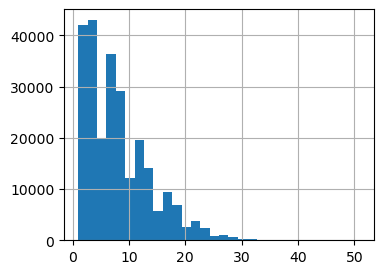

In [32]:
# Распределение признака, полученного агрегированием функцией count()
df['rn'].hist(bins = 30, figsize= (4,3));

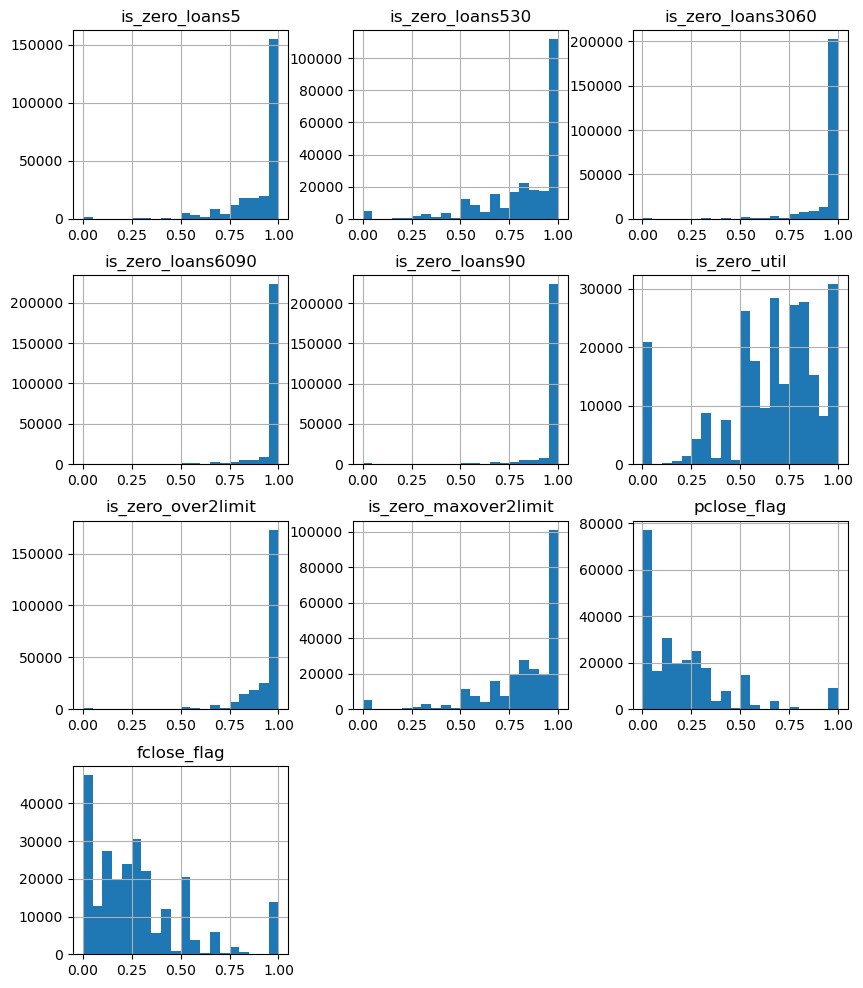

In [33]:
# Распределение признаков, полученных агрегированием функцией mean()
df[flag_cols].hist(bins = 20, figsize= (10, 12));

In [34]:
# Перед пробным моделированием удаляем "айдишники".
df = df.drop(['id'], axis=1)
df

,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,fclose_flag,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,pre_since_opened_9,pre_since_opened_10,pre_since_opened_11,pre_since_opened_12,pre_since_opened_13,pre_since_opened_14,pre_since_opened_15,pre_since_opened_16,pre_since_opened_17,pre_since_opened_18,pre_since_opened_19,pre_since_confirmed_0,pre_since_confirmed_1,pre_since_confirmed_2,pre_since_confirmed_3,pre_since_confirmed_4,pre_since_confirmed_5,pre_since_confirmed_6,pre_since_confirmed_7,pre_since_confirmed_8,pre_since_confirmed_9,pre_since_confirmed_10,pre_since_confirmed_11,pre_since_confirmed_12,pre_since_confirmed_13,pre_since_confirmed_14,pre_since_confirmed_16,pre_since_confirmed_17,pre_since_confirmed_infrequent_sklearn,pre_pterm_0,pre_pterm_1,pre_pterm_2,pre_pterm_3,pre_pterm_4,pre_pterm_6,pre_pterm_7,pre_pterm_8,pre_pterm_9,pre_pterm_10,pre_pterm_11,pre_pterm_12,pre_pterm_13,pre_pterm_14,pre_pterm_15,pre_pterm_16,pre_pterm_17,pre_pterm_infrequent_sklearn,pre_fterm_0,pre_fterm_1,pre_fterm_2,pre_fterm_3,pre_fterm_5,pre_fterm_6,pre_fterm_7,pre_fterm_8,pre_fterm_9,pre_fterm_10,pre_fterm_11,pre_fterm_12,pre_fterm_13,pre_fterm_14,pre_fterm_15,pre_fterm_16,pre_fterm_infrequent_sklearn,pre_till_pclose_0,pre_till_pclose_1,pre_till_pclose_2,pre_till_pclose_3,pre_till_pclose_4,pre_till_pclose_5,pre_till_pclose_6,pre_till_pclose_7,pre_till_pclose_8,pre_till_pclose_9,pre_till_pclose_10,pre_till_pclose_11,pre_till_pclose_12,pre_till_pclose_13,pre_till_pclose_14,pre_till_pclose_15,pre_till_pclose_16,pre_till_fclose_0,pre_till_fclose_1,pre_till_fclose_2,pre_till_fclose_3,pre_till_fclose_4,pre_till_fclose_5,pre_till_fclose_6,pre_till_fclose_7,pre_till_fclose_8,pre_till_fclose_9,pre_till_fclose_10,pre_till_fclose_11,pre_till_fclose_12,pre_till_fclose_13,pre_till_fclose_14,pre_till_fclose_15,pre_loans_credit_limit_0,pre_loans_credit_limit_1,pre_loans_credit_limit_2,pre_loans_credit_limit_3,pre_loans_credit_limit_4,pre_loans_credit_limit_5,pre_loans_credit_limit_6,pre_loans_credit_limit_7,pre_loans_credit_limit_8,pre_loans_credit_limit_9,pre_loans_credit_limit_10,pre_loans_credit_limit_11,pre_loans_credit_limit_12,pre_loans_credit_limit_13,pre_loans_credit_limit_14,pre_loans_credit_limit_15,pre_loans_credit_limit_16,pre_loans_credit_limit_17,pre_loans_credit_limit_18,pre_loans_credit_limit_19,pre_loans_next_pay_summ_0,pre_loans_next_pay_summ_1,pre_loans_next_pay_summ_2,pre_loans_next_pay_summ_3,pre_loans_next_pay_summ_4,pre_loans_next_pay_summ_5,pre_loans_next_pay_summ_6,pre_loans_outstanding_1,pre_loans_outstanding_2,pre_loans_outstanding_3,pre_loans_outstanding_4,pre_loans_outstanding_5,pre_loans_total_overdue_0,pre_loans_max_overdue_sum_1,pre_loans_max_overdue_sum_2,pre_loans_max_overdue_sum_3,pre_loans_credit_cost_rate_0,pre_loans_credit_cost_rate_1,pre_loans_credit_cost_rate_2,pre_loans_credit_cost_rate_3,pre_loans_credit_cost_rate_4,pre_loans_credit_cost_rate_5,pre_loans_credit_cost_rate_6,pre_loans_credit_cost_rate_7,pre_loans_credit_cost_rate_8,pre_loans_credit_cost_rate_9,pre_loans_credit_cost_rate_10,pre_loans_credit_cost_rate_11,pre_loans_credit_cost_rate_13,pre_loans_credit_cost_rate_infrequent_sklearn,pre_loans5_0,pre_loans5_3,pre_loans5_5,pre_loans5_6,pre_loans5_infrequent_sklearn,pre_loans530_0,pre_loans530_2,pre_loans530_3,pre_loans530_6,pre_loans530_13,pre_loans530_16,pre_loans530_18,pre_loans530_infrequent_sklearn,pre_loans3060_5,pre_loans3060_8,pre_loans3060_infrequent_sklearn,pre_loans6090_4,pre_loans6090_infrequent_sklearn,pre_loans90_8,pre_loans90_14,pre_loans90_infrequent_sklearn,pre_util_0,pre_util_1,pre_util_2,pre_util_3,pre_util_4,pre_util_5,pre_util_6,pre_util_7,pre_util_8,pre_util_9,pre_util_10,pre_util_11,pre_util_12,pre_util_13,pre_util_14,pre_util_15,pre_util_16,pre_util_1

In [35]:
# Загрузка датафрейма с целевой переменной.

target = pd.read_csv('train_data/train_target.csv')[0:250000].astype({'id':'int32', 'flag':'int8'})
print(target.shape)
target.head()

(250000, 2)


,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [36]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id      250000 non-null  int32
 1   flag    250000 non-null  int8 
dtypes: int32(1), int8(1)
memory usage: 1.2 MB


In [37]:
# Целевая переменная.
y = target['flag']

In [38]:
# У целевой переменной очень сильный дисбаланс классов.
y.value_counts(normalize=True)

0    0.969064
1    0.030936
Name: flag, dtype: float64

Для того, чтобы понять, с какими данными и значениями метрики мы имеем дело, построим несколько baseline-моделей. Пока без тюнинга гиперпараметров, нормализации и балансировки классов. По результатам полученных метрик и времени, затраченного на их обучение, примем решение, с какими из них продолжим работу более тщательно.

Базовые модели будем строить на пяти "фолдах". Помним, что при кросс-валидации с задачах классификации зазбиение стратифицировано по умолчанию (cv=StratifiedKFold). В каждом из "фолдов" баланс классов целевой переменной равный.

In [39]:
models = [KNeighborsClassifier(), 
          LogisticRegression(random_state=73),
          SVC(random_state=73),
          RandomForestClassifier(random_state=73),
          MLPClassifier(random_state=73),
          CatBoostClassifier(random_seed=73)
         ]

In [40]:
for model in models:
    
    cv_results = cross_validate(model, df, y, scoring='roc_auc', cv=5, n_jobs=-1)
    
    print('Модель: ', model)
    print('Время обучения', (cv_results['fit_time']))
    print('Roc-auc:', cv_results['test_score'].mean().round(4), 'Дисперсия:', cv_results['test_score'].std().round(4))
    print()

Модель:  KNeighborsClassifier()
Время обучения [1.39199567 1.47718096 1.62785935 1.51798844 1.53362513]
Roc-auc: 0.5607 Дисперсия: 0.0017

Модель:  LogisticRegression(random_state=73)
Время обучения [21.27924848 23.59729671 23.38615823 24.25106931 24.80006385]
Roc-auc: 0.7482 Дисперсия: 0.0017

Модель:  SVC(random_state=73)
Время обучения [39592.21808791 44714.65722084 45817.93526697 40762.39048266
 44885.4551084 ]
Roc-auc: 0.6328 Дисперсия: 0.0035

Модель:  RandomForestClassifier(random_state=73)
Время обучения [229.88374543 226.46290922 221.06490731 217.60587478 223.62972713]
Roc-auc: 0.7106 Дисперсия: 0.0055

Модель:  MLPClassifier(random_state=73)
Время обучения [1619.69597101 1517.526438   1507.62225032 1608.32928729 1599.1419661 ]
Roc-auc: 0.6002 Дисперсия: 0.0089

Модель:  <catboost.core.CatBoostClassifier object at 0x000002CD40278F50>
Время обучения [237.68151593 236.97420406 225.48474336 223.94495082 238.59505391]
Roc-auc: 0.7635 Дисперсия: 0.0051



Модели KNeighborsClassifier, SVC, MLPClassifier показывают неудовлетворительную метрику. Кроме того, последние две имеют очень долгое время обучения. Отказываемся от продолжения работы с этими моделями.

С оставшимися тремя моделями продолжим работу. 

Создадим признак, представляющий собой сумму баллов (или "весов тяжести"). Сложим признаки, полученные агрегированием по среднему значению, но с применением коэффициентов множителей (1-1.5-2-2.5-3). Самое большое значение коэффициета применим к "доле отсутствия просрочек более 90 дней", так как такие просрочки наиболее критичны. Соответственно самый малый коэффициент применим к "доле отсутствия просрочек менее 5 дней", как к менее критичным. Получаем: чем выше балл, тем большего доверия заслуживает клиент.

In [41]:
df['is_zero_loans_points'] = df['is_zero_loans5']*1 + df['is_zero_loans530']*1.5 + df['is_zero_loans3060']*2 + df['is_zero_loans6090']*2.5 + df['is_zero_loans90']*3
df['is_zero_loans_points']

0          9.900000
1          8.142857
2          8.000000
3         10.000000
4         10.000000
            ...    
249995     9.884615
249996     9.565217
249997     9.571429
249998     8.000000
249999    10.000000
Name: is_zero_loans_points, Length: 250000, dtype: float64

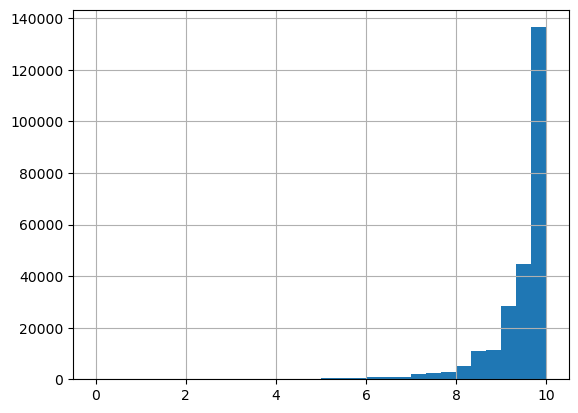

In [42]:
# Распределение нового признака.
df['is_zero_loans_points'].hist(bins=30);

Создадим признак, который суммирует количество временных интервалов, где доля отсутствующих просрочек менее 0.6. Чем больше таких временных интервалов, тем меньшего доверия заслуживает клиент.

In [43]:
is_zero_cols = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']

df['is_zero_loans_risk'] = df[is_zero_cols].lt(0.6).sum(axis=1)
df['is_zero_loans_risk'].value_counts()

0    206608
1     36289
2      3974
3      1487
4      1453
5       189
Name: is_zero_loans_low, dtype: int64

In [44]:
# Посмотрим на метрики на датафрейме с двумя новыми признаками и сравним с метриками baseline-моделей.
models = [LogisticRegression(random_state=73),
          RandomForestClassifier(random_state=73),
          CatBoostClassifier(random_seed=73)
         ]

In [45]:
for model in models:
    
    cv_results = cross_validate(model, df, y, scoring='roc_auc', cv=5, n_jobs=-1)
    
    print('Модель: ', model)
    print('Время обучения', (cv_results['fit_time']))
    print('Roc-auc:', cv_results['test_score'].mean().round(4), 'Дисперсия:', cv_results['test_score'].std().round(4))
    print()

Модель:  LogisticRegression(random_state=73)
Время обучения [23.86881328 20.818187   21.4143312  23.57027531 22.91033292]
Roc-auc: 0.7494 Дисперсия: 0.002

Модель:  RandomForestClassifier(random_state=73)
Время обучения [220.22313356 207.56068826 226.37213588 225.13160372 215.94748306]
Roc-auc: 0.7104 Дисперсия: 0.0058

Модель:  <catboost.core.CatBoostClassifier object at 0x000002CD4E957210>
Время обучения [241.90918064 241.00743961 241.04933906 185.87597919 241.1985364 ]
Roc-auc: 0.7647 Дисперсия: 0.0042



С новыми признаками метрика качества совсем незначительно выросла. Причем было простировано несколько комбинаций "весов-тяжести" и порогов для доли отсутствующих просрочек. Остановились на следующих значениях: 1-1.5-2-2.5-3 и 0,6. Будем использовать эти сгенерированные признаки на следующем этапе выбора лучшей модели.

In [48]:
data = pd.DataFrame({'признаки по умолчанию':[0.7482,0.7106,0.7635],'+ 2 новых признака':[0.7494,0.7104,0.7647],
                     'Изменение, %':[0.16,-0.03,0.16]},
                    index=['LogisticRegression','RandomForestClassifier','CatBoostClassifier'])
data

,признаки по умолчанию,+ 2 новых признака,"Изменение, %"
LogisticRegression,0.7482,0.7494,0.16
RandomForestClassifier,0.7106,0.7104,-0.03
CatBoostClassifier,0.7635,0.7647,0.16
